# Will it snow at the ESE 2024 Kongress?  

Copyright 2024 by [Doulos](https://www.doulos.com)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at:\
http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/doulos/ESE24-edgeAI/blob/main/3_NN_model.ipynb)

## Part3- Machine Learning Model

Install in your virtual environment the requires Python packages (*scikit-learn* and *tensorflow-cpu*). Not needed if the packages are already installed.

Normally we would install regular tensorflow to have support for GPU. Here the model is pretty simple (~100 trainable parameters), so we can affort to run on CPU. And this saves us the potential pains related to GPU drivers and libraries installation.

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
    # on colab
    !wget https://github.com/Doulos/ESE24-edgeAI/raw/refs/heads/main/dataset/dataset.parquet
    path="/content"
else:
    # elsewhere, assume artefacts are in dataset/ relative to this notebook
    path="dataset" 

#!pip install scikit-learn tensorflow-cpu

### Read the weather dataset:

In [2]:
import os
import polars as pl

cleaned_data = pl.read_parquet(os.path.join(path,"dataset.parquet"))

In [3]:
# usefull shorthand
PR_TYPE = "precipitation_form" 
PR_H = "precipitation_height"
TEMP = "temperature_air_mean_2m"
RH = "humidity"

### Generate the dataset for Machine learning

- Here we consider only snow being precipitation_form 3 and 7. How about 8 (mixed liquid/solid precipation)?
- Discard perhaps when certain temperature are above a threshold?
- Discard when precipitation_height below a certain threshold?

For our model, we will assume that we can predict snow fall based on data from the last 3 hours.
We generate a dataframe with column t0,t1,t2,h0,h1,h2 and S.

| temp °C | temp °C | temp °C | humidity % | humidity % | humidity % | snow (0 or 1)  |
|:-------:|:-------:|:-------:|:----------:|:----------:|:----------:|:--------------:|
| now     | now-1h  | now-2h  | now        | now-1h     | now-2h     | now+1h         |
| $t_0$   | $t_1$   | $t_2$   | $h_0$      | $h_1$      | $h2$       | $S$            |

Cirteria for snow:
- PR_TYPE is 3 or 7
- Temperature < 5.0 C $\implies$ we have dediced to cut some of the outliers!

In [4]:
TEMP_THRESHOLD = 5.0
dataset = cleaned_data.select(
            [pl.col(TEMP).alias('t0'), pl.col(TEMP).shift(1).alias('t1'), pl.col(TEMP).shift(2).alias('t2'),
             pl.col(RH).alias('h0'), pl.col(RH).shift(1).alias('h1'), pl.col(RH).shift(2).alias('h2'),
             pl.when((pl.col(TEMP).shift(-1) < TEMP_THRESHOLD) & pl.col(PR_TYPE).shift(-1).is_in([3,7]))
                      .then(1)
                      .otherwise(0)
                      .alias("S")
            ])

In [5]:
dataset.head()

t0,t1,t2,h0,h1,h2,S
f64,f64,f64,f64,f64,f64,i32
-1.417046,null,null,0.501863,null,null,0
-1.392491,-1.417046,null,0.443811,0.501863,null,0
-1.429323,-1.392491,-1.417046,0.617968,0.443811,0.501863,0
-1.429323,-1.429323,-1.392491,0.559916,0.617968,0.443811,1
-1.453878,-1.429323,-1.429323,0.734073,0.559916,0.617968,1


Drop the few rows where we have a null

In [6]:
dataset = dataset.drop_nulls()

### Check Class Imbalance

As expected, most of the samples have the category "no snow". The classes are extremely imbalanced.
Answering blindly "no snow" gives us 96.3% success! Our machine learning algorithm risks to learn this...

In [7]:
size = dataset.height
df0  = dataset.filter(pl.col("S")==0)
df1  = dataset.filter(pl.col("S")==1)
assert size == df0.height + df1.height

In [8]:
print("CLASS repartition SNOW/NO SNOW")
print(f"NO SNOW: {df0.height:6}/{size} = {df0.height/size*100:5.1f}%")
print(f"SNOW   : {df1.height:6}/{size} = {df1.height/size*100:5.1f}%")

CLASS repartition SNOW/NO SNOW
NO SNOW: 167002/173331 =  96.3%
SNOW   :   6329/173331 =   3.7%


Undersample the "no snow" class to have get a dataset with balanced classes

In [9]:
balanced_dataset = pl.concat([df0.sample(df1.height), df1])

In [10]:
print("Check #samples in each class")
print(f"NO SNOW: ", balanced_dataset.filter(pl.col("S")==0).height)
print(f"   SNOW: ", balanced_dataset.filter(pl.col("S")==1).height)

Check #samples in each class
NO SNOW:  6329
   SNOW:  6329


### Train-Validate-Test Split
- 70% training data
- 15% for validation (hyper-parameters tunings)
- 15% for final test

In [11]:
x = balanced_dataset.select("t0","t1","t2","h0","h1","h2")
y = balanced_dataset.select("S")

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_validate_test, y_train, y_validate_test = train_test_split(x,y, test_size=0.3, random_state=21, shuffle=True)
x_validate, x_test, y_validate, y_test = train_test_split(x_validate_test,y_validate_test, test_size=0.5, random_state=42, shuffle=True)

## Model

### Helper functions to measure model performances

In [13]:
import matplotlib.pyplot as plt 
import sklearn.metrics

def plot_training_history(history, metric):
  plt.figure(dpi=150)
  plt.plot(history.epoch, history.history[metric], 'g', label=f'Training {metric}')
  plt.plot(history.epoch, history.history[f'val_{metric}'], 'b', label=f'Validation {metric}')
  plt.title(f'Training and Validation {metric}')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

In [14]:
def show_confusion_matrix(cm, model_name="Confusion Matrix"):
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Samples')
    plt.title(model_name)
    plt.xticks(ticks=[0, 1], labels=['Predicted "No Snow"', ' Predicted "Snow"'])
    plt.yticks(ticks=[0, 1], labels=["It's not snowing!", "It's snowing!"])
    plt.text(0,0,f"{cm[0][0]} (TN)", fontsize=12, color='white', ha='center')
    plt.text(1,0,f"{cm[0][1]} (FP)", fontsize=12, color='black', ha='center')
    plt.text(0,1,f"{cm[1][0]} (FN)", fontsize=12, color='black', ha='center')
    plt.text(1,1,f"{cm[1][1]} (TP)", fontsize=12, color='white', ha='center')
    plt.show()
    
def show_class_performance(model_name, y_test, y_test_pred, show_cm=True):
    cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    if (show_cm):
        show_confusion_matrix(cm, model_name)
    
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    accuracy  = (TP + TN) / (TP + TN + FN + FP)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = (2 * recall * precision) / (recall + precision)
    print(f"{accuracy  = :5.3f}")
    print(f"{recall    = :5.3f}")
    print(f"{precision = :5.3f}")
    print(f"{f1_score  = :5.3f}")

In [15]:
def show_model_performance(history, y_validate, y_pred):
    plot_training_history(history,"loss")
    plot_training_history(history,"accuracy")
    show_class_performance("validation dataset", y_validate, y_pred)

### Create a neural network

We use one hidden layer of 18 neurons, with a dropout layer (30%). \
In fact, for the "snow prediction" model, we could create much simpler model that could give could enough performance (eg. no hidden layer) 

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

model =  tf.keras.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(6,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\ldomaigne\Documents\ESE24_workshop\edgeAI\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 18)                  │             126 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              19 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145 (580.00 B)

 Trainable params: 145 (580.00 B)

 Non-trainable params: 0 (0.00 B)

#### fit the training parameters to the training dataset

In [19]:
NUM_EPOCHS=20
BATCH_SIZE=64
history=model.fit(x_train,y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
                  validation_data=(x_validate,y_validate), verbose=0)

#### compute prediction on validation dataset and show model performance

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


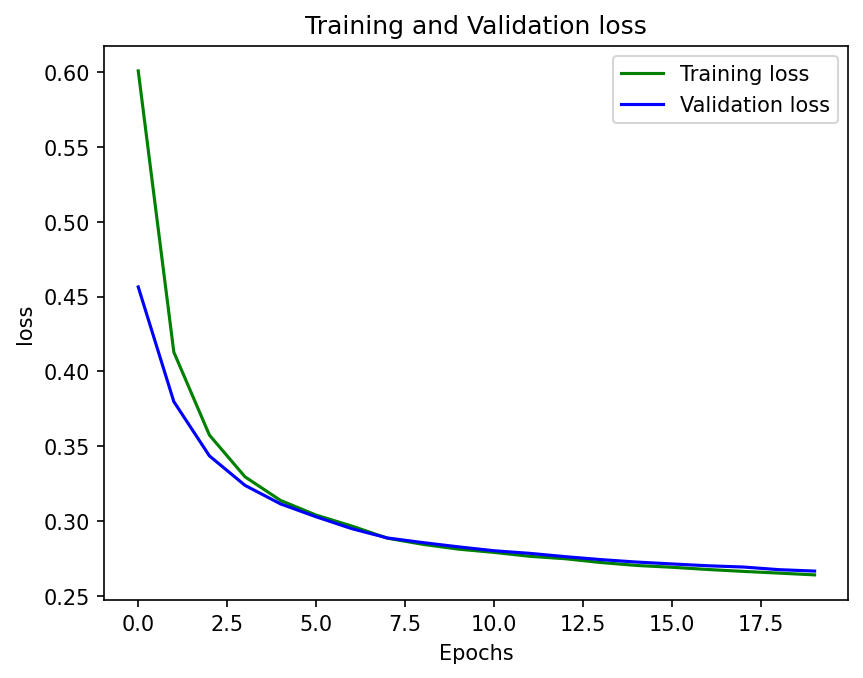

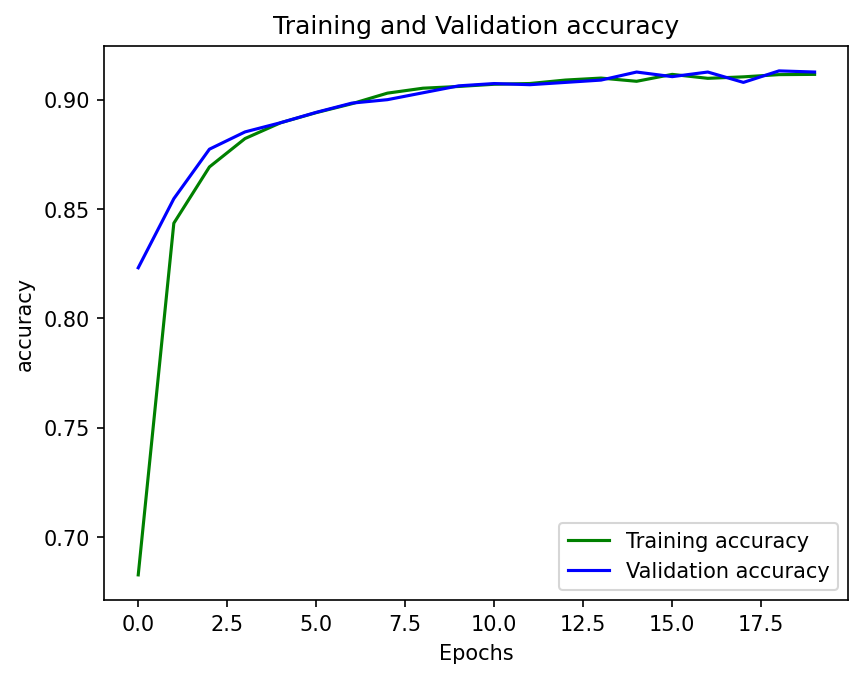

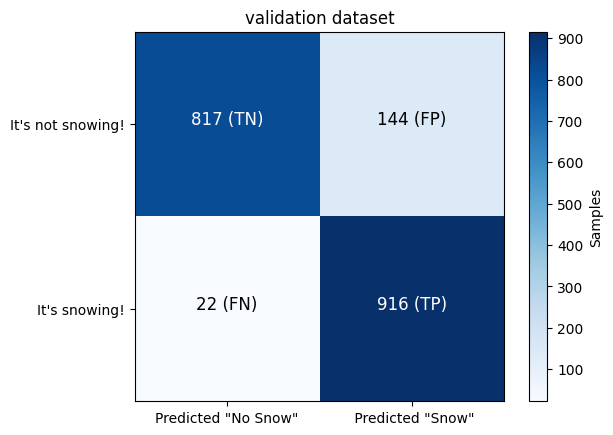

accuracy  = 0.913
recall    = 0.977
precision = 0.864
f1_score  = 0.917


In [20]:
pred = model.predict(x_validate)
pred = (pred>0.5).astype("int32")
show_model_performance(history, y_validate, pred)

### ... Fine-tune models as needed ...

## Gate Test

We assert our model with the **test** dataset before deployment.

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


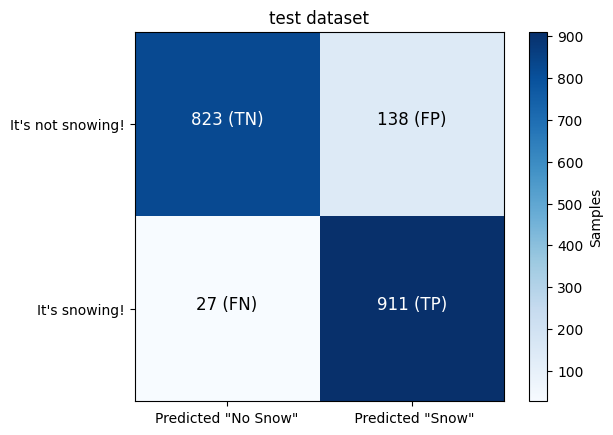

accuracy  = 0.913
recall    = 0.971
precision = 0.868
f1_score  = 0.917


In [21]:
y_test_pred = model.predict(x_test)
y_test_pred = (y_test_pred > 0.5).astype("int32")
show_class_performance("test dataset", y_test, y_test_pred)

## Save model and test data set

In [22]:
model.export("snow_forecast")
x_test.write_parquet("x_test.parquet")
y_test.write_parquet("y_test.parquet")

INFO:tensorflow:Assets written to: snow_forecast\assets


INFO:tensorflow:Assets written to: snow_forecast\assets


Saved artifact at 'snow_forecast'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1926404065808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1926404066384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1926404066576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1926404066960: TensorSpec(shape=(), dtype=tf.resource, name=None)
